In [1]:
# %%
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.models import mobilenet_v2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


In [2]:
# %%
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %%
# Paths
ct_dataset_path = "C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/BrainTumor/Brain Tumor CT scan Images"
mri_dataset_path = "C:/Users/karti/Desktop/Projects/DiagnoSphere/Dataset/BrainTumor/Brain Tumor MRI images"
img_size = 224
batch_size = 32


Using device: cuda


In [3]:
# %%
# Transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# %%
# Datasets
ct_dataset = ImageFolder(root=ct_dataset_path, transform=transform)
mri_dataset = ImageFolder(root=mri_dataset_path, transform=transform)
combined_dataset = ConcatDataset([ct_dataset, mri_dataset])

# %%
# Split 80-20
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [4]:
# %%
# Model
model = mobilenet_v2(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  # Freeze base

# Modify classifier
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)
model.to(device)


c:\Users\karti\anaconda3\envs\torch_skin\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\karti\anaconda3\envs\torch_skin\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\karti/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:11<00:00, 1.29MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [5]:
# %%
# Loss & Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:

# %%
# Save best model
best_val_acc = 0.0
checkpoint_path = "best_model_brain.pth"


In [7]:
# %%
# Training
num_epochs = 10
train_acc_hist, val_acc_hist = [], []


In [8]:
for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)

    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loop.set_postfix(loss=loss.item())

    train_acc = correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        torch.save(model.state_dict(), checkpoint_path)
        best_val_acc = val_acc
        print("✅ Best model saved!")


Epoch 1/10 - Train Acc: 0.8825, Val Acc: 0.9262
✅ Best model saved!


Epoch 2/10 - Train Acc: 0.9154, Val Acc: 0.9376
✅ Best model saved!


Epoch 3/10 - Train Acc: 0.9273, Val Acc: 0.9241


Epoch 4/10 - Train Acc: 0.9428, Val Acc: 0.9595
✅ Best model saved!


Epoch 5/10 - Train Acc: 0.9407, Val Acc: 0.9662
✅ Best model saved!


Epoch 6/10 - Train Acc: 0.9491, Val Acc: 0.9584


Epoch 7/10 - Train Acc: 0.9485, Val Acc: 0.9652


Epoch 8/10 - Train Acc: 0.9593, Val Acc: 0.9600


Epoch 9/10 - Train Acc: 0.9594, Val Acc: 0.9636


Epoch 10/10 - Train Acc: 0.9591, Val Acc: 0.9714
✅ Best model saved!


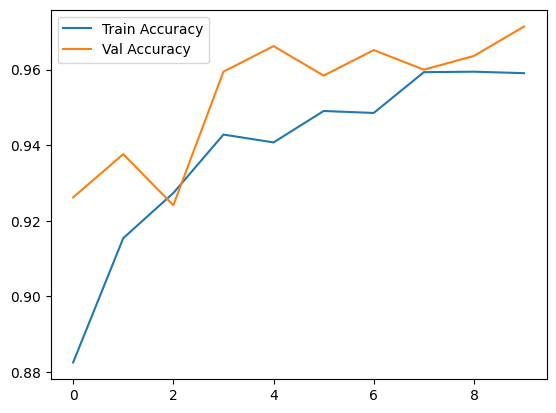

In [9]:
# %%
# Plot
plt.plot(train_acc_hist, label="Train Accuracy")
plt.plot(val_acc_hist, label="Val Accuracy")
plt.legend()
plt.show()